In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

from utils import EarlyStopping

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import networkx as nx

import dhg
from dhg import Graph
from dhg import Hypergraph
from dhg.data import BaseData
from dhg.data import Cora
from dhg.data import CoauthorshipCora
from dhg.data import CocitationCora
from dhg.data import YelpRestaurant
from dhg.data import Yelp3k
from dhg.data import IMDB4k
from dhg.data import Cooking200
import dhg.datapipe as dd
from dhg.models import GCN
from dhg.random import set_seed
from dhg.metrics import GraphVertexClassificationEvaluator as Evaluator

c:\Users\lolis\Documents\UNI\Kurser\master_thesis\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Data

## Normal Cora

In [35]:
dataset = Cora()

hyperedges = dataset['edge_list']

X = dataset['features'].to(device)
labels = dataset['labels'].to(device)
G = Hypergraph(dataset['num_vertices'], hyperedges).to(device)

In [36]:
# Print the number of classes
num_classes = dataset['num_classes']
print("Number of classes:", num_classes)

# Print the number of nodes
num_nodes = dataset['num_vertices']
print("Number of nodes:", num_nodes)

# Print the number of node features
num_node_features = dataset['dim_features']
print("Number of node features:", num_node_features)

# Print number of edges
num_edges = len(hyperedges)
print("Number of edges:", num_edges)

# Print the node features
print("Node features:", dataset['features'].shape)

# Print the labels
print("Labels:", dataset['labels'].shape)

# Print the train, validation, and test masks
train_mask = dataset['train_mask'].to(device)
val_mask = dataset['val_mask'].to(device)
test_mask = dataset['test_mask'].to(device)
print("Train mask:", train_mask)
print("Validation mask:", val_mask)
print("Test mask:", test_mask)

Number of classes: 7
Number of nodes: 2708
Number of node features: 1433
Number of edges: 10858
Node features: torch.Size([2708, 1433])
Labels: torch.Size([2708])
Train mask: tensor([ True,  True,  True,  ..., False, False, False], device='cuda:0')
Validation mask: tensor([False, False, False,  ..., False, False, False], device='cuda:0')
Test mask: tensor([False, False, False,  ...,  True,  True,  True], device='cuda:0')


## Coauthorship Cora

In [3]:
dataset = CoauthorshipCora()
set_seed(42)
X = dataset['features'].to(device)
# Normalize the features
dd.norm_ft(X)
labels = dataset['labels'].to(device)
G = Hypergraph(dataset['num_vertices'], dataset['edge_list']).to(device)

In [4]:
# Print the data object
print("Data object:", dataset)

# Print the number of classes
num_classes = dataset['num_classes']
print("Number of classes:", num_classes)

# Print the number of nodes
num_nodes = dataset['num_vertices']
print("Number of nodes:", num_nodes)

# Print the number of node features
num_node_features = dataset['dim_features']
print("Number of node features:", num_node_features)

# Print number of edges
num_edges = dataset['num_edges']
print("Number of edges:", num_edges)

# Print maximum edge size
max_edge_size = max([len(edge) for edge in dataset['edge_list']])
print("Maximum edge size:", max_edge_size)

# Print the node features
print("Node features:", dataset['features'].shape)

# Print the labels
print("Labels:", dataset['labels'].shape)

# Print the train, validation, and test masks
train_mask = dataset['train_mask'].to(device)
val_mask = dataset['val_mask'].to(device)
test_mask = dataset['test_mask'].to(device)
print("Training nodes:", train_mask.sum().item())
print("Validation nodes:", val_mask.sum().item())
print("Test nodes:", test_mask.sum().item())

Data object: This is coauthorship_cora dataset:
  ->  num_classes
  ->  num_vertices
  ->  num_edges
  ->  dim_features
  ->  features
  ->  edge_list
  ->  labels
  ->  train_mask
  ->  val_mask
  ->  test_mask
Please try `data['name']` to get the specified data.
Number of classes: 7
Number of nodes: 2708
Number of node features: 1433
Number of edges: 1072
Maximum edge size: 43
Node features: torch.Size([2708, 1433])
Labels: torch.Size([2708])
Training nodes: 140
Validation nodes: 2568
Test nodes: 2568


In [5]:
# Manual train/val/test split
train_mask = torch.zeros(num_nodes, dtype=torch.bool).to(device)
test_mask = torch.zeros(num_nodes, dtype=torch.bool).to(device)

train_mask[:1354] = True
test_mask[1354:] = True

# Shuffle the nodes
perm = torch.randperm(num_nodes)
train_mask = train_mask[perm]
test_mask = test_mask[perm]
val_mask = test_mask.clone()

## Cocitation Cora

In [3]:
dataset = CocitationCora()
set_seed(42)
X = dataset['features'].to(device)
labels = dataset['labels'].to(device)
G = Hypergraph(dataset['num_vertices'], dataset['edge_list']).to(device)

In [4]:
# Print the data object
print("Data object:", dataset)

# Print the number of classes
num_classes = dataset['num_classes']
print("Number of classes:", num_classes)

# Print the number of nodes
num_nodes = dataset['num_vertices']
print("Number of nodes:", num_nodes)

# Print the number of node features
num_node_features = dataset['dim_features']
print("Number of node features:", num_node_features)

# Print number of edges
num_edges = dataset['num_edges']
print("Number of edges:", num_edges)

# Print maximum edge size
max_edge_size = max([len(edge) for edge in dataset['edge_list']])
print("Maximum edge size:", max_edge_size)

# Print the node features
print("Node features:", dataset['features'].shape)

# Print the labels
print("Labels:", dataset['labels'].shape)

# Print the train, validation, and test masks
train_mask = dataset['train_mask'].to(device)
val_mask = dataset['val_mask'].to(device)
test_mask = dataset['test_mask'].to(device)
print("Train mask:", train_mask)
print("Validation mask:", val_mask)
print("Test mask:", test_mask)

Data object: This is cocitation_cora dataset:
  ->  num_classes
  ->  num_vertices
  ->  num_edges
  ->  dim_features
  ->  features
  ->  edge_list
  ->  labels
  ->  train_mask
  ->  val_mask
  ->  test_mask
Please try `data['name']` to get the specified data.
Number of classes: 7
Number of nodes: 2708
Number of node features: 1433
Number of edges: 1579
Maximum edge size: 5
Node features: torch.Size([2708, 1433])
Labels: torch.Size([2708])
Train mask: tensor([False, False, False,  ..., False, False, False], device='cuda:0')
Validation mask: tensor([True, True, True,  ..., True, True, True], device='cuda:0')
Test mask: tensor([True, True, True,  ..., True, True, True], device='cuda:0')


In [5]:
# Manual train/val/test split
train_mask = torch.zeros(num_nodes, dtype=torch.bool).to(device)
test_mask = torch.zeros(num_nodes, dtype=torch.bool).to(device)

train_mask[:1000] = True
test_mask[1000:] = True

# Shuffle the nodes
perm = torch.randperm(num_nodes)
train_mask = train_mask[perm]
test_mask = test_mask[perm]
val_mask = test_mask.clone()

## other Co-citation cora

In [134]:
from datasets.data import load

class Args:
    def __init__(self):
        self.data = 'cocitation'
        self.dataset = 'cora'
        self.split = 4

args = Args()

dataset, train_mask, test_mask = load(args)
set_seed(42)

dataset.keys()

X = torch.tensor(dataset['features']).to(device)
labels = torch.argmax(torch.tensor(dataset['labels']), dim=1).to(device)
G = Hypergraph(dataset['n'], list(dataset['hypergraph'].values())).to(device)

number of hyperedges is 1579


In [135]:
# Print the number of classes
num_classes = 7
print("Number of classes:", num_classes)

# Print the number of nodes
num_nodes = dataset['n']
print("Number of nodes:", num_nodes)

# Print the number of node features
num_node_features = dataset['features'].shape[1]
print("Number of node features:", num_node_features)

# Print number of edges
num_edges = len(dataset['hypergraph'])
print("Number of edges:", num_edges)

# Print the node features
print("Node features:", dataset['features'].shape)

# Print the labels
print("Labels:", dataset['labels'].shape)

# Print the train, validation, and test masks
train_mask = torch.tensor(train_mask)
print("Train mask:", len(train_mask))
train_mask = torch.zeros(num_nodes, dtype=torch.bool).scatter_(0, train_mask, 1).to(device)
test_mask = torch.tensor(test_mask)
print("Test mask:", len(test_mask))
test_mask = torch.zeros(num_nodes, dtype=torch.bool).scatter_(0, test_mask, 1).to(device)
val_mask = test_mask
print("Train mask:", train_mask)
print("Validation mask:", val_mask)
print("Test mask:", test_mask)

Number of classes: 7
Number of nodes: 2708
Number of node features: 1433
Number of edges: 1579
Node features: (2708, 1433)
Labels: (2708, 7)
Train mask: 140
Test mask: 2568
Train mask: tensor([False, False,  True,  ..., False, False, False], device='cuda:0')
Validation mask: tensor([ True,  True, False,  ...,  True,  True,  True], device='cuda:0')
Test mask: tensor([ True,  True, False,  ...,  True,  True,  True], device='cuda:0')


## Manual Co-citation cora

In [142]:
dataset = Cora()
# Initialize hyperedges as a dictionary where each key is an article (node)
citing = dict()
cited = dict()

# Create hyperedges based on citation relationships
for source, target in dataset['edge_list']:
    citing[source] = citing.get(source, set()).union({target})
    cited[target] = cited.get(target, set()).union({source})

# Create a list of hyperedges
hyperedges = []
for source, targets in citing.items():
    hyperedges.append(tuple(targets))

for target, sources in cited.items():
    hyperedges.append(tuple(sources))

for e in hyperedges:
    if len(e) == 0:
        hyperedges.remove(e)

X = dataset['features'].to(device)
labels = dataset['labels'].to(device)
G = Hypergraph(dataset['num_vertices'], hyperedges).to(device)

In [143]:
# class MyCocitationCora(BaseData):
#     def __init__(self, data_root: Optional[str] = None) -> None:
#         super().__init__('MyCocitationCora', data_root)
#         self._content = {
#             "num_classes": 7,
#             "num_vertices": 2708,
#             "num_edges": 4664,
#             "dim_features": 1433,
#             'features': {
#                 'upon': [{ 'filename': 'features.pkl', 'md5': '05b45e9c38cc95f4fc44b3668cc9ddc9' }],
#                 'loader': load_from_pickle,
#                 'preprocess': [to_tensor, partial(norm_ft, ord=1)],
#             },
#             'edge_list': {
#                 'upon': [{ 'filename': 'edge_list.pkl', 'md5': 'f488389c1edd0d898ce273fbd27822b3' }],
#                 'loader': load_from_pickle,
#             },
#             'labels': {
#                 'upon': [{ 'filename': 'labels.pkl', 'md5': 'e506014762052c6a36cb583c28bdae1d' }],
#                 'loader': load_from_pickle,
#                 'preprocess': [to_long_tensor],
#             },
#             'train_mask': {
#                 'upon': [{ 'filename': 'train_mask.pkl', 'md5': 'a11357a40e1f0b5cce728d1a961b8e13' }],
#                 'loader': load_from_pickle,
#                 'preprocess': [to_bool_tensor],
#             },
#             'val_mask': {
#                 'upon': [{ 'filename': 'val_mask.pkl', 'md5': '355544da566452601bcfa74d30539a71' }],
#                 'loader': load_from_pickle,
#                 'preprocess': [to_bool_tensor],
#             },
#             'test_mask': {
#                 'upon': [{ 'filename': 'test_mask.pkl', 'md5': 'bbfc87d661560f55f6946f8cb9d602b9' }],
#                 'loader': load_from_pickle,
#                 'preprocess': [to_bool_tensor],
#             },
#         }

In [144]:
# Print the number of classes
num_classes = dataset['num_classes']
print("Number of classes:", num_classes)

# Print the number of nodes
num_nodes = dataset['num_vertices']
print("Number of nodes:", num_nodes)

# Print the number of node features
num_node_features = dataset['dim_features']
print("Number of node features:", num_node_features)

# Print number of edges
num_edges = len(hyperedges)
print("Number of edges:", num_edges)

# Print the node features
print("Node features:", dataset['features'].shape)

# Print the labels
print("Labels:", dataset['labels'].shape)

# Print the train, validation, and test masks
train_mask = dataset['train_mask'].to(device)
val_mask = dataset['val_mask'].to(device)
test_mask = dataset['test_mask'].to(device)
print("Train mask:", train_mask)
print("Validation mask:", val_mask)
print("Test mask:", test_mask)

Number of classes: 7
Number of nodes: 2708
Number of node features: 1433
Number of edges: 5416
Node features: torch.Size([2708, 1433])
Labels: torch.Size([2708])
Train mask: tensor([ True,  True,  True,  ..., False, False, False], device='cuda:0')
Validation mask: tensor([False, False, False,  ..., False, False, False], device='cuda:0')
Test mask: tensor([False, False, False,  ...,  True,  True,  True], device='cuda:0')


## Yelp Restaurant

In [7]:
dataset = Yelp3k()
set_seed(42)
X = dataset['features'].to(device)
labels = dataset['labels'].to(device)
G = Hypergraph(dataset['num_vertices'], dataset['edge_list']).to(device)

In [8]:
# Print the data object
#print("Data object:", dataset)

# Print the number of classes
num_classes = dataset['num_classes']
print("Number of classes:", num_classes)

# Print the number of nodes
num_nodes = dataset['num_vertices']
print("Number of nodes:", num_nodes)

# Print the number of node features
num_node_features = dataset['dim_features']
print("Number of node features:", num_node_features)

# Print the edge index
#print("Edge index:", dataset['edge_list'])

# Print the node features
#print("Node features:", dataset['features'])

# Print the labels
#print("Labels:", dataset['labels'])

train_mask = torch.zeros(num_nodes, dtype=torch.bool).to(device)
train_mask[:num_nodes // 2] = 1
val_mask = torch.zeros(num_nodes, dtype=torch.bool).to(device)
val_mask[num_nodes // 2: 3 * num_nodes // 4] = 1
test_mask = torch.zeros(num_nodes, dtype=torch.bool).to(device)
test_mask[3 * num_nodes // 4:] = 1


# Print the train, validation, and test masks
# train_mask = dataset['train_mask'].to(device)
# val_mask = dataset['val_mask'].to(device)
# test_mask = dataset['test_mask'].to(device)
print("Train mask:", train_mask)
print("Validation mask:", val_mask)
print("Test mask:", test_mask)

Number of classes: 6
Number of nodes: 3855
Number of node features: 1862
Train mask: tensor([ True,  True,  True,  ..., False, False, False], device='cuda:0')
Validation mask: tensor([False, False, False,  ..., False, False, False], device='cuda:0')
Test mask: tensor([False, False, False,  ...,  True,  True,  True], device='cuda:0')


## IMDB

In [14]:
dataset = IMDB4k()
set_seed(42)
X = dataset['features'].to(device)
labels = dataset['labels'].to(device)
G = Hypergraph(dataset['num_vertices'], dataset['edge_by_director']).to(device)

In [15]:
# Print the data object
#print("Data object:", dataset)

# Print the number of classes
num_classes = dataset['num_classes']
print("Number of classes:", num_classes)

# Print the number of nodes
num_nodes = dataset['num_vertices']
print("Number of nodes:", num_nodes)

# Print the number of node features
num_node_features = dataset['dim_features']
print("Number of node features:", num_node_features)

# Print the edge index
#print("Edge index:", dataset['edge_list'])

# Print the node features
#print("Node features:", dataset['features'])

# Print the labels
#print("Labels:", dataset['labels'])

train_mask = torch.zeros(num_nodes, dtype=torch.bool).to(device)
train_mask[:num_nodes // 2] = 1
val_mask = torch.zeros(num_nodes, dtype=torch.bool).to(device)
val_mask[num_nodes // 2: 3 * num_nodes // 4] = 1
test_mask = torch.zeros(num_nodes, dtype=torch.bool).to(device)
test_mask[3 * num_nodes // 4:] = 1


# Print the train, validation, and test masks
# train_mask = dataset['train_mask'].to(device)
# val_mask = dataset['val_mask'].to(device)
# test_mask = dataset['test_mask'].to(device)
print("Training nodes:", train_mask.sum().item())
print("Validation nodes:", val_mask.sum().item())
print("Test nodes:", test_mask.sum().item())

Number of classes: 3
Number of nodes: 4278
Number of node features: 3066
Training nodes: 2139
Validation nodes: 1069
Test nodes: 1070


## Cooking 200

In [5]:
dataset = Cooking200()
set_seed(2021)
print(dataset)
X = torch.eye(dataset["num_vertices"]).to(device)
labels = dataset['labels'].to(device)
G = Hypergraph(dataset['num_vertices'], dataset['edge_list']).to(device)

This is cooking_200 dataset:
  ->  num_classes
  ->  num_vertices
  ->  num_edges
  ->  edge_list
  ->  labels
  ->  train_mask
  ->  val_mask
  ->  test_mask
Please try `data['name']` to get the specified data.


In [6]:
# Print the number of classes
num_classes = dataset['num_classes']
print("Number of classes:", num_classes)

# Print the number of nodes
num_nodes = dataset['num_vertices']
print("Number of nodes:", num_nodes)

# Print the number of node features
num_node_features = X.shape[1]
print("Number of node features:", num_node_features)

# Print the train, validation, and test masks
train_mask = dataset['train_mask'].to(device)
val_mask = dataset['val_mask'].to(device)
test_mask = dataset['test_mask'].to(device)
print("Training nodes:", train_mask.sum().item())
print("Validation nodes:", val_mask.sum().item())
print("Test nodes:", test_mask.sum().item())

Number of classes: 20
Number of nodes: 7403
Number of node features: 7403
Training nodes: 200
Validation nodes: 200
Test nodes: 7003


# Models

## HCoGNN

In [17]:
from models.HCoGNN import HCoGNN_node_classifier
from models.ActionNetwork import action_network
from models.EnvironmentNetwork import environment_network

action_net = action_network(num_node_features, "mean", nn.GELU(), [], 0, 0).to(device)
environment_net = environment_network(num_node_features, "mean", nn.GELU(), [512], 1, 0).to(device)
model = HCoGNN_node_classifier(num_node_features, num_classes, 1, nn.GELU(), action_net, environment_net, [64], dropout=0.5).to(device)

print("Model:", model)
print("Model Device:", next(model.parameters()).device)

Model: HCoGNN_node_classifier(
  (classifier): ModuleList(
    (0): Linear(in_features=1433, out_features=64, bias=True)
    (1): GELU(approximate='none')
    (2): Linear(in_features=64, out_features=7, bias=True)
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (activation): GELU(approximate='none')
  (action_net): action_network(
    (layers): ModuleList(
      (0): Linear(in_features=1433, out_features=1433, bias=True)
      (1): GELU(approximate='none')
    )
    (activation): GELU(approximate='none')
    (lin_update): Linear(in_features=1433, out_features=1433, bias=True)
    (action_layer): Linear(in_features=1433, out_features=4, bias=True)
    (dropout): Dropout(p=0, inplace=False)
  )
  (environment_net): environment_network(
    (layers): ModuleList(
      (0): Linear(in_features=1433, out_features=512, bias=True)
      (1): GELU(approximate='none')
      (2): Linear(in_features=512, out_features=1433, bias=True)
      (3): GELU(approximate='none')
    )
    (activation): GEL

In [18]:
params = [{'params': model.classifier.parameters(), 'lr': 0.01, 'weight_decay': 1e-5}, 
          {'params': model.action_net.parameters(), 'lr': 0.001, 'weight_decay': 1e-5}, 
          {'params': model.environment_net.parameters(), 'lr': 0.001, 'weight_decay': 1e-5}]

# Adam optimizer
optimizer = torch.optim.Adam(params)

# L-BFGS optimizer
# optimizer = torch.optim.LBFGS(model.parameters(), lr=0.01, max_iter=20, max_eval=25, history_size=100, line_search_fn='strong_wolfe')

#edge_weight = random_walk_matrix(G)
edge_weight = (None,None)

print("Optimizer:", optimizer)
print("Data Device:", X.device)

Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    weight_decay: 1e-05

Parameter Group 1
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 1e-05

Parameter Group 2
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 1e-05
)
Data Device: cuda:0


## Hypergraph conv

In [10]:
from dhg.models import HGNN

model = HGNN(num_node_features, 16, num_classes, False, drop_rate=0.1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model.to(device)

print("Model:", model)
print("Optimizer:", optimizer)
print("Model Device:", next(model.parameters()).device)
print("Data Device:", X.device)

Model: HGNN(
  (layers): ModuleList(
    (0): HGNNConv(
      (act): ReLU(inplace=True)
      (drop): Dropout(p=0.1, inplace=False)
      (theta): Linear(in_features=1433, out_features=16, bias=True)
    )
    (1): HGNNConv(
      (act): ReLU(inplace=True)
      (drop): Dropout(p=0.5, inplace=False)
      (theta): Linear(in_features=16, out_features=7, bias=True)
    )
  )
)
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)
Model Device: cuda:0
Data Device: cuda:0


## HyperGCN

In [62]:
from dhg.models import HyperGCN
from utils import random_walk_matrix

v2e_weight, e2v_weight = random_walk_matrix(G)

model = HyperGCN(num_node_features, 64, num_classes, False, drop_rate=0.5)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

model.to(device)

print("Model:", model)
print("Optimizer:", optimizer)
print("Model Device:", next(model.parameters()).device)
print("Data Device:", X.device)

Model: HyperGCN(
  (layers): ModuleList(
    (0): HyperGCNConv(
      (act): ReLU(inplace=True)
      (drop): Dropout(p=0.5, inplace=False)
      (theta): Linear(in_features=1433, out_features=64, bias=True)
    )
    (1): HyperGCNConv(
      (act): ReLU(inplace=True)
      (drop): Dropout(p=0.5, inplace=False)
      (theta): Linear(in_features=64, out_features=7, bias=True)
    )
  )
)
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    weight_decay: 0.0005
)
Model Device: cuda:0
Data Device: cuda:0


# Training

In [19]:
from utils import train, validate

# Run the training
early_stopper = EarlyStopping(patience=50, mode='max', delta=-0.01)
for epoch in range(1000):
    loss = train(model, optimizer, X, G, labels, train_mask)

    _, val_accuracy = validate(model, X, G, labels, train_mask, val_mask)
    if early_stopper(model, val_accuracy):
        print("Early stopping")
        break

    if epoch % 50 == 0:
        train_accuracy, val_accuracy = validate(model, X, G, labels, train_mask, val_mask)
        print(f'Epoch {epoch+1}, Loss: {loss:.4f}')
        print(f'Training Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}')

model.load_state_dict(early_stopper.best_model)

Epoch 1, Loss: 1.9449
Training Accuracy: 0.2980, Validation Accuracy: 0.3044
Epoch 51, Loss: 1.5527
Training Accuracy: 0.6130, Validation Accuracy: 0.4379
Epoch 101, Loss: 1.3009
Training Accuracy: 0.8700, Validation Accuracy: 0.5626
Epoch 151, Loss: 1.2429
Training Accuracy: 0.9210, Validation Accuracy: 0.6054
Epoch 201, Loss: 1.2352
Training Accuracy: 0.9280, Validation Accuracy: 0.6259
Epoch 251, Loss: 1.1792
Training Accuracy: 0.9870, Validation Accuracy: 0.6575
Epoch 301, Loss: 1.1794
Training Accuracy: 0.9870, Validation Accuracy: 0.6751
Epoch 351, Loss: 1.1792
Training Accuracy: 0.9870, Validation Accuracy: 0.6827
Epoch 401, Loss: 1.1780
Training Accuracy: 0.9880, Validation Accuracy: 0.6862
Epoch 451, Loss: 1.1779
Training Accuracy: 0.9880, Validation Accuracy: 0.6897
Epoch 501, Loss: 1.1770
Training Accuracy: 0.9890, Validation Accuracy: 0.6973
Epoch 551, Loss: 1.1759
Training Accuracy: 0.9900, Validation Accuracy: 0.7026
Epoch 601, Loss: 1.1758
Training Accuracy: 0.9900, Vali

<All keys matched successfully>

Ratio of actions in layer 0: [1. 0. 0. 0.] (S, L, B, I)
Test Accuracy: 0.4075, Training Accuracy: 0.4770, Validation Accuracy: 0.4075


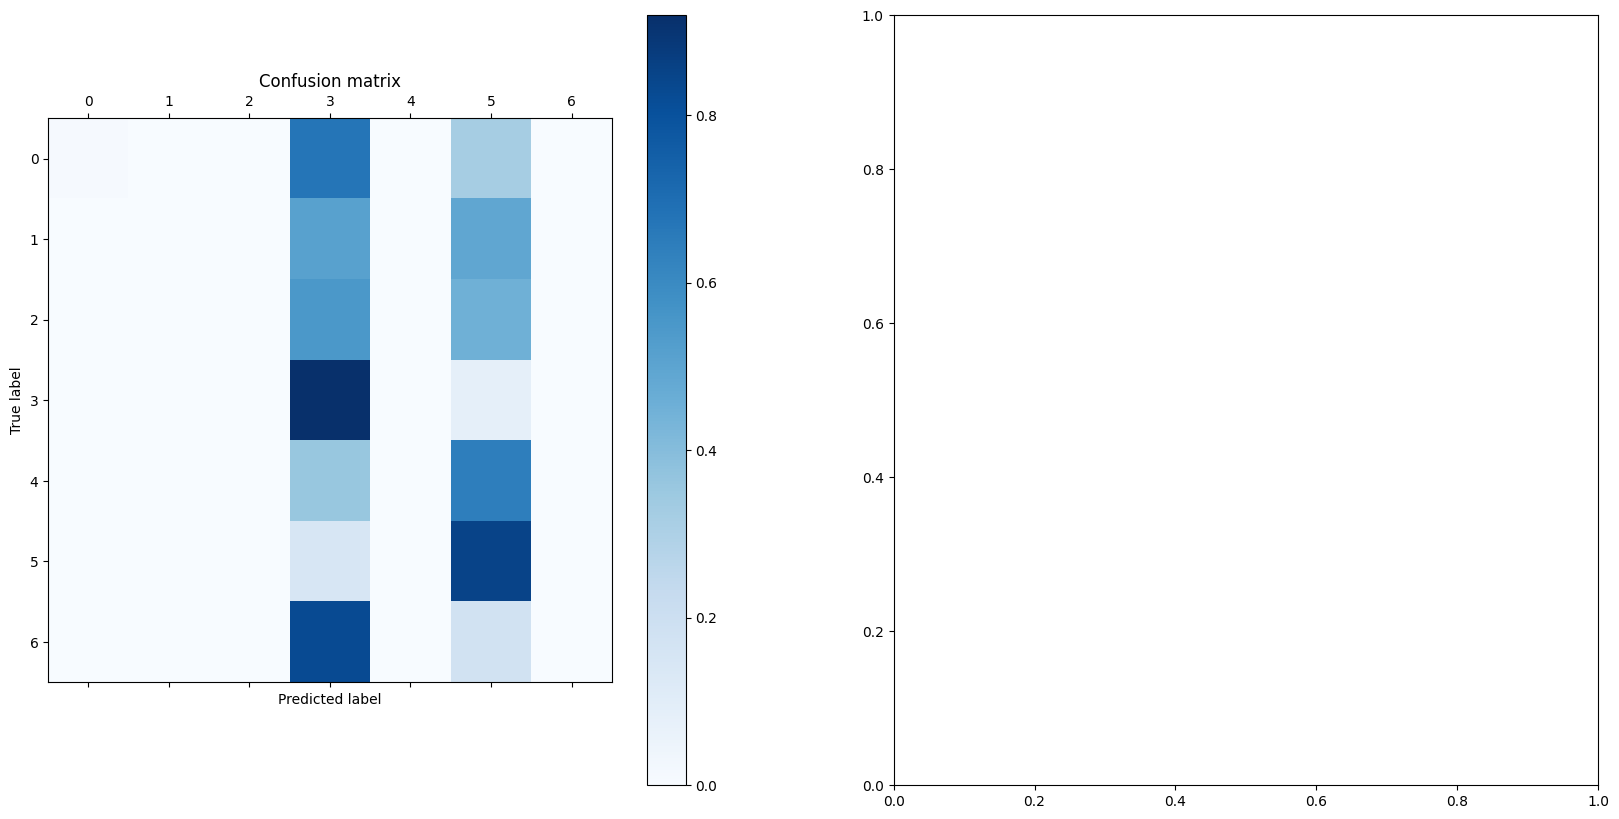

In [21]:
from utils import test, visualize_results

# Test the model
train_accuracy, val_accuracy = validate(model, X, G, labels, train_mask, val_mask)
accuracy, predictions = test(model, X, G, labels, test_mask)
print(f'Test Accuracy: {accuracy:.4f}, Training Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}')

visualize_results(model, X, G, labels, test_mask)